# Supplemantary Figure 1 - Light Change

## 1 - Import Necessary Modules

In [24]:
import cartopy 
import cartopy.io.shapereader as shpreader 
import cartopy.io.shapereader as Reader 
import geopandas as gpd
import matplotlib.pyplot as plt 
import numpy as np 
import proplot
import rioxarray
import xarray as xr 

from cartopy.feature import ShapelyFeature 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes 
from netCDF4 import Dataset 
from shapely.geometry import mapping
from wrf import xy_to_ll 

# warnings
import warnings
warnings.filterwarnings('ignore')

## 2 - Open Datasets

In [4]:
# dataset path names (1990 and 2013)
years = ['F101992.v4b',
         'F182013.v4c']

appending = '_web.stable_lights.avg_vis.tif'

# list of 2 images
ims = []
for y in years:
    
    file = fr'{y}{appending}'
    im = xr.open_rasterio(file)
    ims.append(im)

In [10]:
# write nodata information
ims[0].rio.write_nodata(255, inplace=True)
ims[1].rio.write_nodata(255, inplace=True)

<xarray.DataArray (band: 1, y: 16801, x: 43201)>
[725820001 values with dtype=uint8]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 75.0 74.99 74.98 74.98 ... -64.97 -64.98 -64.99 -65.0
  * x        (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0 180.0
Attributes:
    transform:            (0.0083333333, 0.0, -180.00416666665, 0.0, -0.00833...
    crs:                  +init=epsg:4326
    res:                  (0.0083333333, 0.0083333333)
    is_tiled:             0
    nodatavals:           (nan,)
    scales:               (1.0,)
    offsets:              (0.0,)
    AREA_OR_POINT:        Area
    TIFFTAG_XRESOLUTION:  1
    TIFFTAG_YRESOLUTION:  1
    _FillValue:           255

## 4 - Define Shapefile Paths

In [ ]:
# shapefile path names for:

# Turkey - country
turkey_shape = r'turkey_provinces.shp'

# Ankara - province
ankara_shape = r'ankara_shape.shp'

# Ankara - districts
ankara_shape_district = r'ankara_shape_districts.shp'

## 5 - Plot Functions

In [20]:
def clip_to_city(data, shapefile, x_dims, y_dims):
    """
    Clips xarray Dataset into given shapefile
    
    Parameters:
        data: xr.Dataset -- xarray dataset to be clipped
        shapefile: gpd.DataDrame -- shapefile data to clip
        x_dims: str -- x dimension name
        y_dims: str -- y dimension name
        
    Returns:
        xr.Dataset -- clipped dataset
    """
    
    # set spatial dim names
    data= data.rio.set_spatial_dims(x_dim=x_dims, y_dim=y_dims)
    
    # clip data into shapefile
    clipped = data.rio.clip(shapefile.geometry.apply(mapping), shapefile.crs, all_touched=True, invert=False)
    
    return clipped

def plot_turkey(province, turkey_shape, ankara_shape,
                ankara_shape_district, lon_lat_limits):
    """
    Create light plots
    
    Parameters:
        province: str -- province name
        turkey_shape: str -- turkey shape path
        ankara_shape: str -- ankara shape path
        ankara_shape_district: str -- ankara districts shape path
        lon_lat_limits: dict -- dict containing ankara's lon/lat limits
        
    Returns:
        plt.figure
    """
    
    # lon and lat information to clip the data into approximate turkey borders
    lat_tur = slice(51.9, 30.9)
    lon_tur = slice(25.7, 41.7)
    
    # x and y dimension names
    x_dim = 'x'
    y_dim = 'y'
    
    # open ankara gpd dataframe
    shp_ankara = gpd.read_file(ankara_shape)
    
    # projection
    cart_proj = cartopy.crs.Mercator()

    # Create Figure
    fig_array = [[1,1,2,2]]
    fig, axs = proplot.subplots(fig_array, 
                                aspect=30, axwidth=15,
                                proj=cart_proj, hratios=(1),
                                includepanels=True, wspace=3
                                )
    
    # format figure
    for i in range(2):
        
        axs[i].format(lonlim=(lon_lat_limits[province][0],
                              lon_lat_limits[province][1]),
                      latlim=(lon_lat_limits[province][2],
                              lon_lat_limits[province][3]),
                      labels=False, longrid=False, latgrid = False,
                      nsteps=100, labelsize=15, abc='(a)',
                      abcloc='ul', abcsize = 40)

        
    # add shapefiles to figure
    # Turkey - country
    shape_feature_turkey = ShapelyFeature(shpreader.Reader(turkey_shape).geometries(),
                                          cartopy.crs.PlateCarree(),
                                          facecolor='none', edgecolor = 'black',
                                          linewidth = 0.5, zorder = 0.3)
    
    # Ankara - province
    shape_feature_ankara = ShapelyFeature(shpreader.Reader(ankara_shape).geometries(),
                                          cartopy.crs.PlateCarree(),
                                          facecolor='none', edgecolor = 'black',
                                          linewidth = 6.2, zorder = 0.3)
    
    # Ankara - districts
    shape_feature_ankara_dist = ShapelyFeature(shpreader.Reader(ankara_shape_district).geometries(),
                                               cartopy.crs.PlateCarree(),
                                               facecolor='none', edgecolor = 'white',
                                               linewidth = 0.5, zorder = 0.3)

    # add shapefiles as features
    for i in range(2):

        axs[i].add_feature(shape_feature_turkey)
        axs[i].add_feature(shape_feature_ankara)
        axs[i].add_feature(shape_feature_ankara_dist)
        
    
    # cmap
    cmap = proplot.Colormap('Solar')
    
    # clip and plot data
    for i in range(2):
        
        # nearest turkey borders
        data_spec = ims[i].squeeze().sel(y=lat_tur, x=lon_tur)
        
        # reproject
        data_spec = data_spec.rio.reproject('EPSG:4326')
        
        # clip into turkey shapefile
        dt_clipped = clip_to_city(data_spec, shp_ankara, x_dim, y_dim)
        
        # nodata to np.nan
        dt_clipped = xr.where(dt_clipped==255, np.nan, dt_clipped)
        
        # write nodata
        dt_clipped = dt_clipped.rio.write_nodata(np.nan)
        
        # plot mesh
        mesh = dt_clipped.plot.pcolormesh(ax = axs[i], 
                             alpha=1, add_colorbar = False,
                             cmap=cmap, transform=cartopy.crs.PlateCarree(),
                             zorder = 0.1, add_labels=False
                             )
        # title
        mesh.title=''
    
    # save figure
    plt.savefig(r'FigureS1.jpeg',
                bbox_inches='tight', optimize=True,
                progressive=True, dpi=500)

## 6 - Create Plots

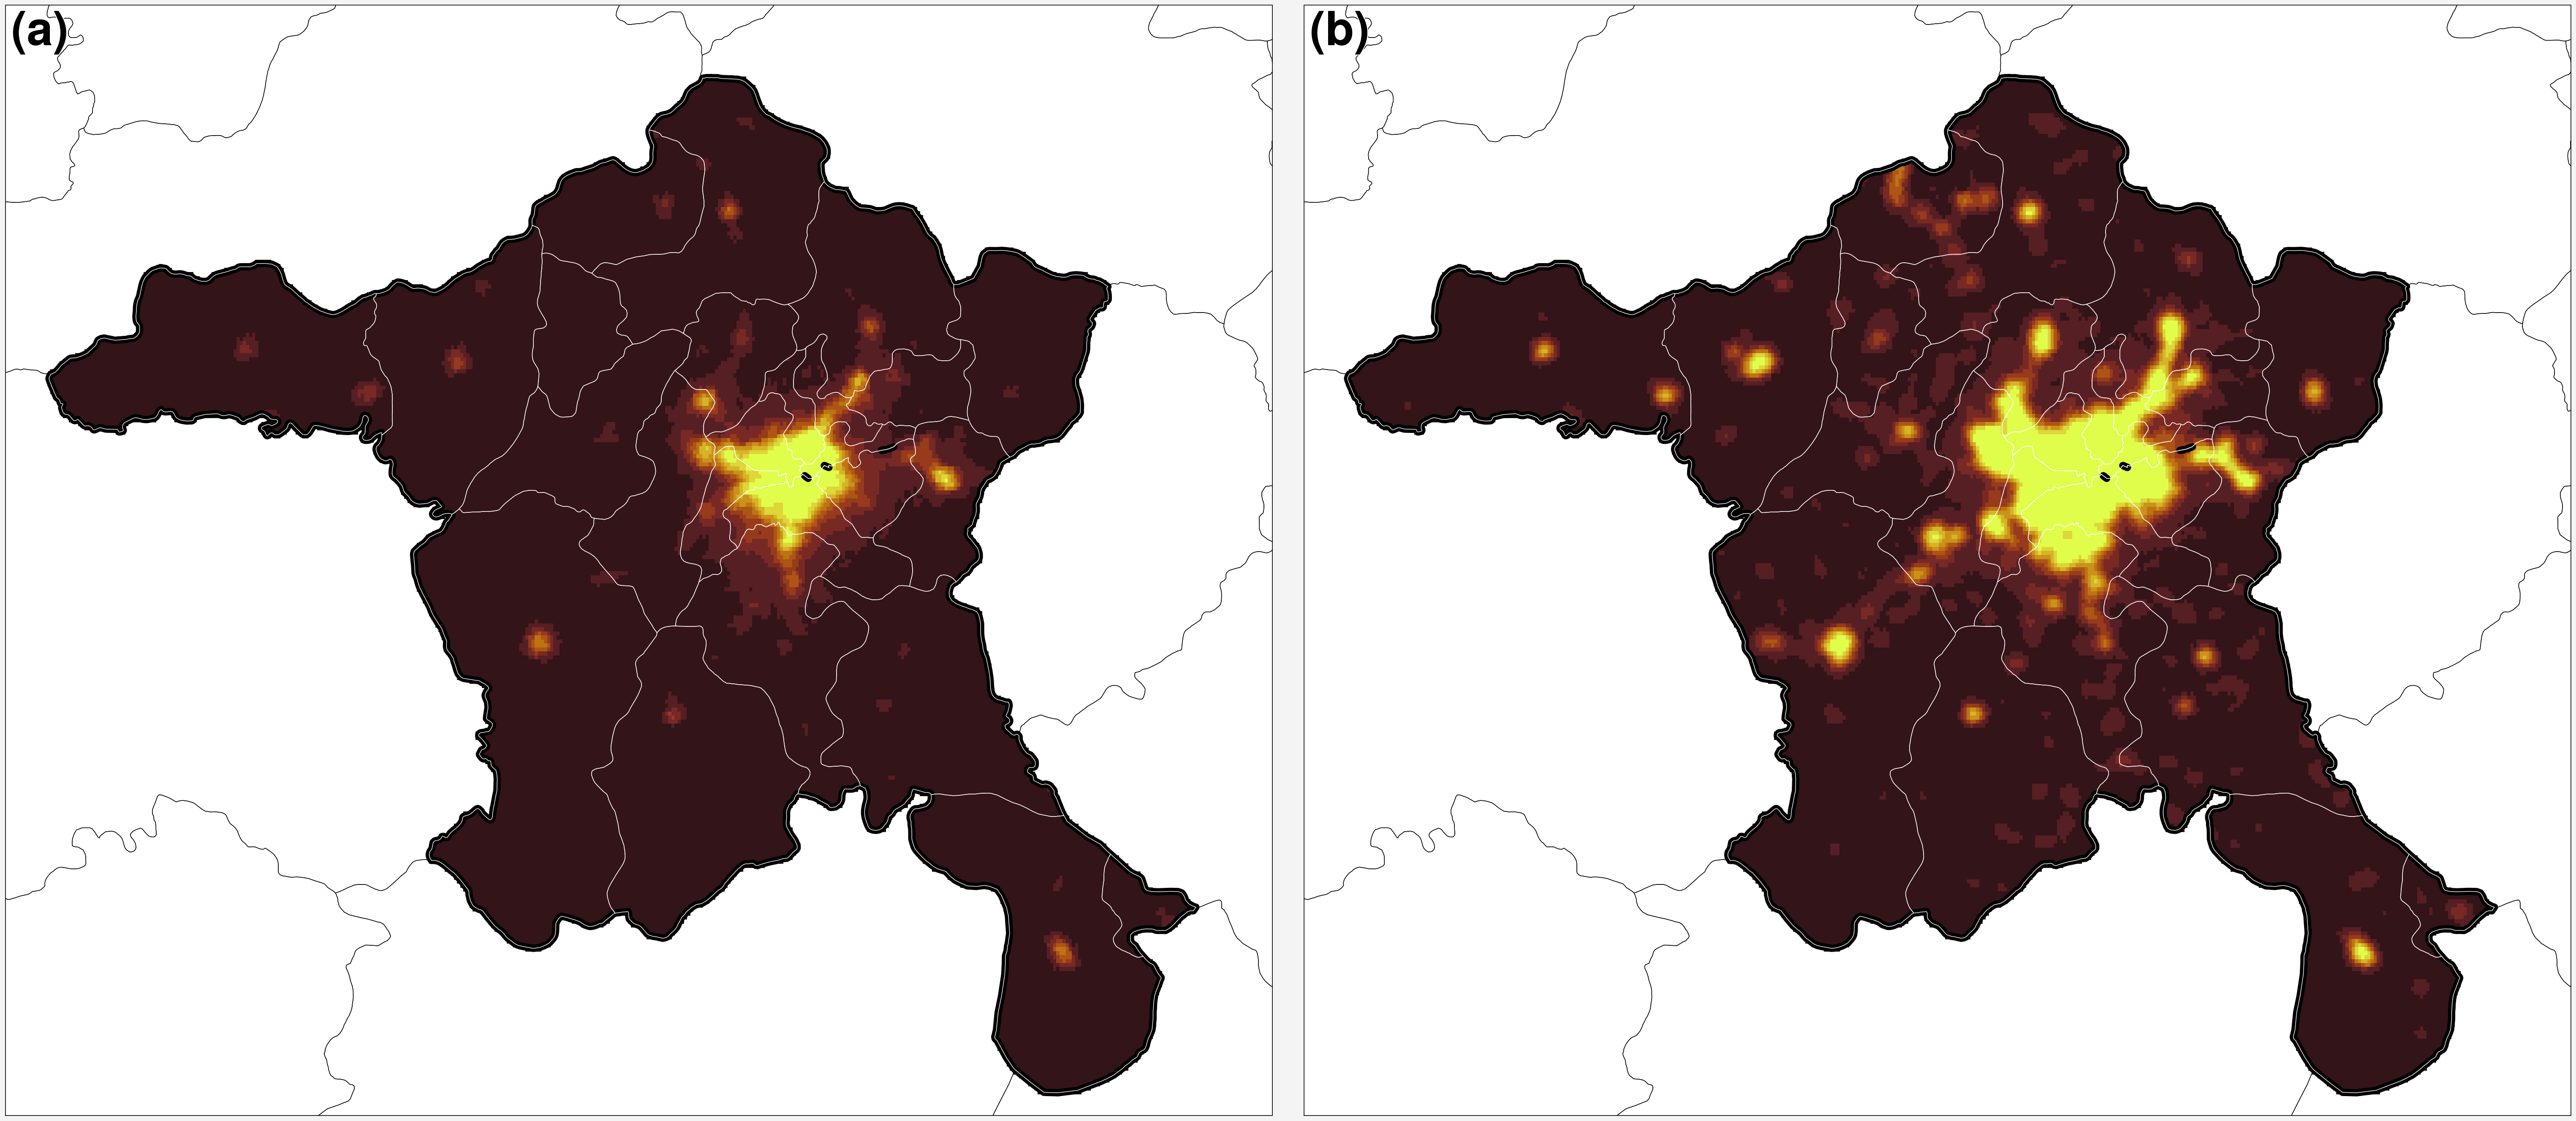

In [25]:
# province name
province = 'Ankara'

# longitude latitude extent for Ankara
lon_lat_limits = {
                  'Ankara':[30.7, 34.1, 38.6, 40.9]
                 }

# figure
fig = plot_turkey(province, turkey_shape, ankara_shape, ankara_shape_district, lon_lat_limits)